In [61]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [62]:
def arrival_time(lambda_):
    return np.random.exponential(1 / lambda_)

def time_of_stay(mu):
    return np.random.exponential(mu)

def simulate_arrival_time_day(lambda_, days_simulation):

    total = 0
    arrivals_time = []

    while total < days_simulation:
        time_arrival = arrival_time(lambda_)
        arrivals_time.append(time_arrival)

        total += time_arrival

    return np.array(np.cumsum(arrivals_time))

def extract_new_ward(patient, transition_probability):

    possible_wards = np.arange(0, transition_probability.shape[0])
    new_ward = np.random.choice(possible_wards, p=transition_probability[patient, : ])

    return new_ward

def list_arrive_patient(arrivals_time):
    result = []
    for idx, sublist in enumerate(arrivals_time):
        for value in sublist:
            result.append((value, idx))
    
    # Sort by arrival time (first element of tuple)
    result.sort()
    return result

def count_new_departures(leaving_time, processed, current_time, n_types):
    departures_count = [0] * n_types

    for i, (t, p_type) in enumerate(leaving_time):
        if not processed[i] and t < current_time:
            departures_count[p_type] += 1
            processed[i] = True  # mark as processed

    return departures_count, processed

In [63]:
def simulate(
    transition_probability,
    lambdas,
    mean_length_stay,
    bed_capacity,
    days_simulation
):
    n_types = len(lambdas)
    type_patients = np.arange(n_types)

    occupied_bed = np.zeros(n_types, dtype=int)
    rejected_patients = np.zeros(n_types, dtype=int)

    # Time-tracking
    occupied_bed_timeline = []
    rejected_patients_timeline = []
    time_timeline = []

    # Relocation tracking: [original_type, relocated_to]
    relocated_patients = np.zeros((n_types, n_types), dtype=int)

    # Simulate arrivals per type
    arrival_time_total = [
        simulate_arrival_time_day(lambdas[tp], days_simulation)
        for tp in type_patients
    ]
    mix_arrivals_time = list_arrive_patient(arrival_time_total)
    # Leave tracking
    leaving_time = []
    processed = []

    for arrival_time, patient_type in mix_arrivals_time:
        # Discharge patients whose time has come
        departures_count, processed = count_new_departures(
            leaving_time, processed, arrival_time, n_types
        )
        occupied_bed -= departures_count

        # Try to admit to primary ward
        if occupied_bed[patient_type] < bed_capacity[patient_type]:
            occupied_bed[patient_type] += 1
            stay_time = time_of_stay(mean_length_stay[patient_type])
            departure_time = arrival_time + stay_time
            leaving_time.append((departure_time, patient_type))
            processed.append(False)
        else:
            # Try redirecting
            new_ward = extract_new_ward(patient_type, transition_probability)

            if occupied_bed[new_ward] < bed_capacity[new_ward]:
                occupied_bed[new_ward] += 1
                stay_time = time_of_stay(mean_length_stay[new_ward])
                departure_time = arrival_time + stay_time
                leaving_time.append((departure_time, new_ward))
                processed.append(False)

                # Track relocation from original type to new ward
                relocated_patients[patient_type, new_ward] += 1
            else:
                rejected_patients[patient_type] += 1

        # Record snapshot
        occupied_bed_timeline.append(occupied_bed.copy())
        rejected_patients_timeline.append(rejected_patients.copy())
        time_timeline.append(arrival_time)

    return (
        np.array(occupied_bed_timeline),
        np.array(rejected_patients_timeline),
        np.array(time_timeline),
        leaving_time,
        relocated_patients,
        mix_arrivals_time
    )


def compute_cost(rej_hist, reloc_matrix, urgency_point):
    rejected = rej_hist[-1, :-1]  # exclude F*
    relocated = np.sum(reloc_matrix[:-1, :], axis=1)
    return (rejected + relocated) @ urgency_point


In [ ]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0],  # From A
    [0.20, 0.00, 0.50, 0.15, 0.15, 0],  # From B
    [0.30, 0.20, 0.00, 0.20, 0.30, 0],  # From C
    [0.35, 0.30, 0.05, 0.00, 0.30, 0],  # From D
    [0.20, 0.10, 0.60, 0.10, 0.00, 0],  # From E
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
])

lambdas = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length_of_stay = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]
days_simulation = 100

urgency_point = [7, 5, 2, 10, 5]

[60 24  4 16 27 34]
[64 23  3 15 26 34]
[68 22  2 14 25 34]
[72 21  1 13 24 34]
[76 20  0 12 23 34]
[   0.   176.6  574.9  662.5 1286.6]
[55 29  4 16 27 34]
[54 33  3 15 26 34]
[53 37  2 14 25 34]
[52 41  1 13 24 34]
[51 45  0 12 23 34]
[   0.  -397.9  -73.4 -115.   -18.5]
[55 24  9 16 27 34]
[54 23 13 15 26 34]
[53 22 17 14 25 34]
[52 21 21 13 24 34]
[51 20 25 12 23 34]
[   0.   -10.7  350.2  602.4 1198. ]
[55 24  4 21 27 34]
[54 23  3 25 26 34]
[53 22  2 29 25 34]
[52 21  1 33 24 34]
[51 20  0 37 23 34]
[   0.  -101.8  255.3  671.8 1024.8]
[55 24  4 16 32 34]
[54 23  3 15 36 34]
[53 22  2 14 40 34]
[52 21  1 13 44 34]
[51 20  0 12 48 34]
[   0.  -205.   169.6  782.4 1221.7]


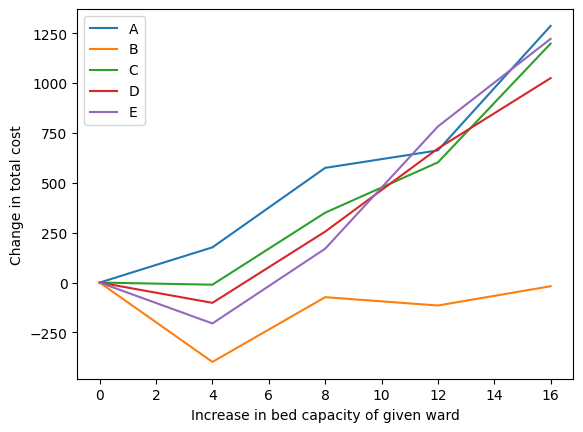

In [72]:
num_sim = 10

for ward in range(len(lambdas) - 1):    # Skip F
    results = []
    bed_capacities = np.array([56, 25, 5, 17, 28, 34])
    for _ in range(5):
        sims = []
        for _ in range(num_sim):
            occ_bed_hist, rej_hist, time_hist, leaves, reloc_matrix, mix_time_arrival = simulate(P, lambdas, mean_length_of_stay, bed_capacities, days_simulation)
            cost = compute_cost(rej_hist, reloc_matrix, urgency_point)
            sims.append(cost)
        results.append(np.mean(sims))
        diff_arr = np.repeat(-1, len(lambdas))
        diff_arr[-1] = 0
        diff_arr[ward] = 4
        bed_capacities += diff_arr
        print(bed_capacities)
    print(results - results[0])
    plt.plot([4 * i for i in range(5)], results - results[0])
plt.legend(["A", "B", "C", "D", "E"])
plt.xlabel("Increase in bed capacity of given ward")
plt.ylabel("Change in total cost")
plt.show()

[52 26  6 18 29 34]
[48 27  7 19 30 34]
[44 28  8 20 31 34]
[40 29  9 21 32 34]
[36 30 10 22 33 34]
[   0.    89.9  469.1  821.1 1352. ]
[57 21  6 18 29 34]
[58 17  7 19 30 34]
[59 13  8 20 31 34]
[60  9  9 21 32 34]
[61  5 10 22 33 34]
[  0.  215.9 241.4 685.7 989.7]
[57 26  1 18 29 34]
[  0.  135.2]
[57 26  6 13 29 34]
[58 27  7  9 30 34]
[59 28  8  5 31 34]
[60 29  9  1 32 34]
[   0.   647.1 2061.9 3646.4 5857.8]
[57 26  6 18 24 34]
[58 27  7 19 20 34]
[59 28  8 20 16 34]
[60 29  9 21 12 34]
[61 30 10 22  8 34]
[   0.    -4.6 -168.8 -210.5 -410.9]


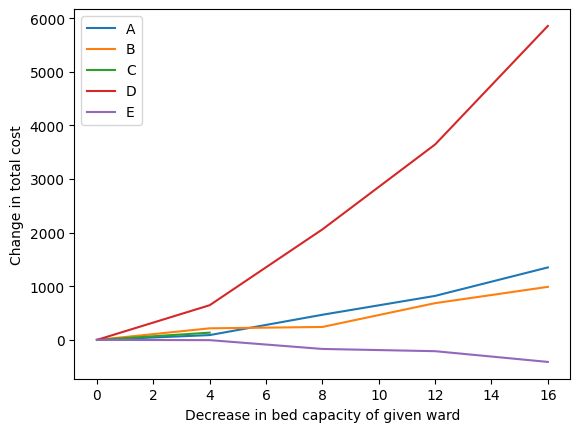

In [74]:
num_sim = 10

for ward in range(len(lambdas) - 1):    # Skip F
    results = []
    bed_capacities = np.array([56, 25, 5, 17, 28, 34])
    for _ in range(5):
        sims = []
        for _ in range(num_sim):
            occ_bed_hist, rej_hist, time_hist, leaves, reloc_matrix, mix_time_arrival = simulate(P, lambdas, mean_length_of_stay, bed_capacities, days_simulation)
            cost = compute_cost(rej_hist, reloc_matrix, urgency_point)
            sims.append(cost)
        results.append(np.mean(sims))
        diff_arr = np.repeat(-1, len(lambdas))
        diff_arr[-1] = 0
        diff_arr[ward] = 4
        bed_capacities -= diff_arr
        if np.any(bed_capacities < 0):
            break
        print(bed_capacities)
    print(results - results[0])
    plt.plot([4 * i for i in range(len(results))], results - results[0])
plt.legend(["A", "B", "C", "D", "E"])
plt.xlabel("Decrease in bed capacity of given ward")
plt.ylabel("Change in total cost")
plt.show()